Working with Neural Network Models

© Hans Nieminen, Satakunta University of Applied Sciences

# Exercise 11.1

In [ ]:
import torch
from torch import nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from timeit import default_timer as timer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch_size = 64

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False)

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

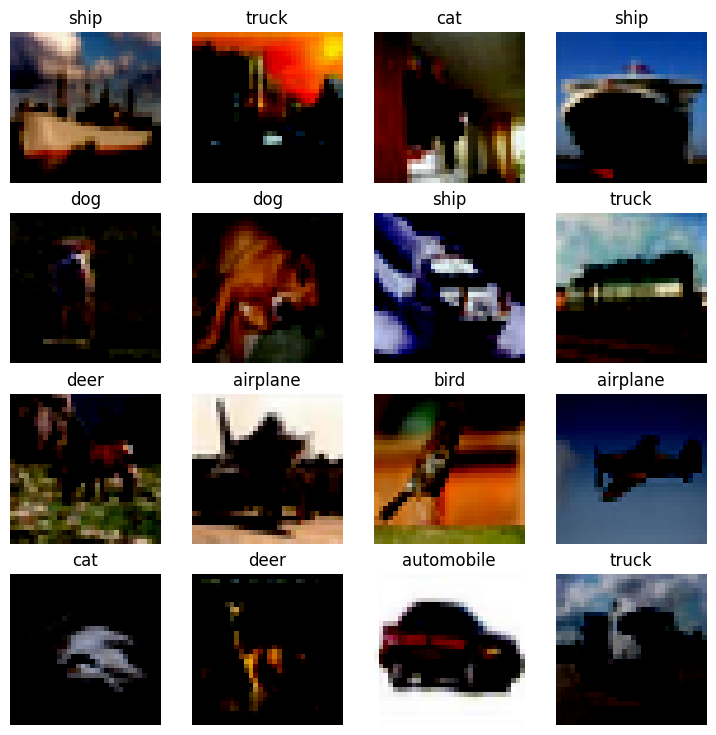

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(classes[label])
    plt.axis(False)
plt.show()

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 8 * 8,
                      out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,
                      out_features=10)  # number of classes in CIFAR-10
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 8 * 8,
                      out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,
                      out_features=10),  # number of classes in CIFAR-10
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(121)
#torch.manual_seed_all(121)
model = CIFAR10_CNN().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                      lr=0.001)

In [ ]:
summary(model,
        input_size=[64, 3, 32, 32],
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CIFAR10_CNN (CIFAR10_CNN)                [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (conv_block)                [64, 3, 32, 32]      [64, 32, 8, 8]       --                   True
│    └─Conv2d (0)                        [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
│    └─ReLU (1)                          [64, 16, 32, 32]     [64, 16, 32, 32]     --                   --
│    └─MaxPool2d (2)                     [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
│    └─Conv2d (3)                        [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
│    └─ReLU (4)                          [64, 32, 16, 16]     [64, 32, 16, 16]     --                   --
│    └─MaxPool2d (5)                     [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Sequential (classifi

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, device = 'cpu'):
    train_loss = 0
    correct = 0
    total = 0

    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Feed forward
        outputs = model(X)

        # 2. Loss and accuracy (for a batch)
        loss = loss_fn(outputs, y)
        train_loss += loss.item()
        _, y_pred = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

        # 3. Initialize gradients
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Update weights
        optimizer.step()

    # Average loss and accuracy per batch
    epoch_loss = train_loss / len(data_loader)
    epoch_acc = 100 * correct / total
    print(f"Train loss: {epoch_loss:.5f} | Train accuracy: {epoch_acc:.2f}%")

In [ ]:
def test_step(data_loader, model, loss_fn, device = 'cpu'):
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, y_pred = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()

    print(f"Test accuracy: {100 * correct / total:.2f}%")

In [ ]:
import datetime
epochs = 10
author = 'Hans Nieminen'

for epoch in tqdm(range(epochs)):
    dt = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\nEpoch: {epoch + 1} / Training made by {author} at {dt}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device
    )

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 1 / Training made by Hans Nieminen at 2024-11-28 06:34:04
---------
Train loss: 1.47549 | Train accuracy: 47.00%
Test accuracy: 56.35%

Epoch: 2 / Training made by Hans Nieminen at 2024-11-28 06:34:21
---------
Train loss: 1.13227 | Train accuracy: 59.86%
Test accuracy: 62.32%

Epoch: 3 / Training made by Hans Nieminen at 2024-11-28 06:34:38
---------
Train loss: 0.96451 | Train accuracy: 66.05%
Test accuracy: 65.44%

Epoch: 4 / Training made by Hans Nieminen at 2024-11-28 06:34:55
---------
Train loss: 0.85456 | Train accuracy: 70.24%
Test accuracy: 66.94%

Epoch: 5 / Training made by Hans Nieminen at 2024-11-28 06:35:11
---------
Train loss: 0.77015 | Train accuracy: 73.16%
Test accuracy: 67.66%

Epoch: 6 / Training made by Hans Nieminen at 2024-11-28 06:35:28
---------
Train loss: 0.69802 | Train accuracy: 75.74%
Test accuracy: 67.72%

Epoch: 7 / Training made by Hans Nieminen at 2024-11-28 06:35:44
---------
Train loss: 0.63374 | Train accuracy: 78.16%
Test accuracy: 67.97%